<a href="https://colab.research.google.com/github/zupanasolutions/identification-of-medicinal-plants-using-deep-learning/blob/master/medicinal_plants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount drive for dataset

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# import appropriate libraries

In [ ]:
import os
from shutil import copy2
import csv


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install tensorflow_hub

In [ ]:
import tensorflow_hub as hub

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

# Set path to the data set located inside google drive

In [ ]:
data_root = ("/content/drive/My Drive/Azubi/images")

# Rescale images and split data into training and validation sets

In [ ]:
IMAGE_SHAPE = (224, 224)                                         
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)


Found 300 images belonging to 5 classes.
Found 1200 images belonging to 5 classes.


# visualize the data

In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 5))

# The image labels are mapped onto indices and 
# the labels written to a text file

In [ ]:
 print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'ASOKAM': 0, 'AYYAPPANA': 1, 'INSULIN PLANT': 2, 'KAKURA': 3, 'KARPPOOORAM': 4}


In [ ]:
!cat labels.txt

ASOKAM
AYYAPPANA
INSULIN PLANT
KAKURA
KARPPOOORAM

# Load a pretrained model from tensorflow hub

In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


# Choose an Optimizer and compile the model

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

In [ ]:
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

# Set number of epocs and other parameters and fit the model

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=50,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/50
38/38 [==============================] - 541s 14s/step - loss: 0.9075 - acc: 0.6500 - val_loss: 0.4871 - val_acc: 0.8267
Epoch 2/50
38/38 [==============================] - 208s 5s/step - loss: 0.3157 - acc: 0.9042 - val_loss: 0.2980 - val_acc: 0.8700
Epoch 3/50
38/38 [==============================] - 206s 5s/step - loss: 0.2070 - acc: 0.9458 - val_loss: 0.2380 - val_acc: 0.9000
Epoch 4/50
38/38 [==============================] - 206s 5s/step - loss: 0.1473 - acc: 0.9600 - val_loss: 0.2221 - val_acc: 0.8933
Epoch 5/50
38/38 [==============================] - 205s 5s/step - loss: 0.1179 - acc: 0.9658 - val_loss: 0.1871 - val_acc: 0.9100
Epoch 6/50
38/38 [==============================] - 208s 5s/step - loss: 0.0954 - acc: 0.9775 - val_loss: 0.1889 - val_acc: 0.9133
Epoch 7/50
38/38 [==============================] - 207s 5s/step - loss: 0.0856 - acc: 0.9833 - val_loss: 0.1811 - val_acc: 0.9167
Epoch 8/50
38/38 [==============================] - 207s 5s/step - loss: 0.0783 - 

# Evaluating the performance of the model

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

10/10 [==============================] - 28s 3s/step - loss: 0.1421 - acc: 0.9467
Final loss: 0.14
Final accuracy: 94.67%


# Plots of training and validation accuracy

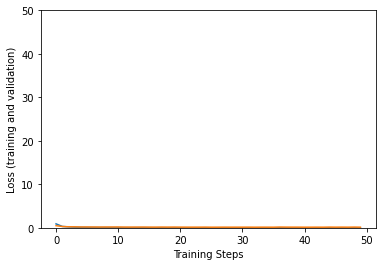

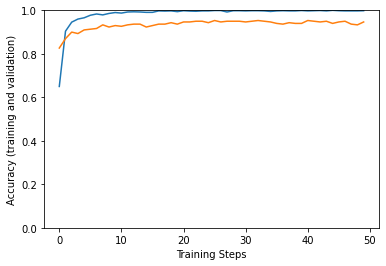

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [ ]:

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Asokam' 'Ayyappana' 'Insulin Plant' 'Kakura' 'Karppoooram']


In [ ]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 5)


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Insulin Plant' 'Kakura' 'Asokam' 'Karppoooram' 'Insulin Plant' 'Asokam'
 'Karppoooram' 'Kakura' 'Insulin Plant' 'Kakura' 'Asokam' 'Karppoooram'
 'Asokam' 'Insulin Plant' 'Karppoooram' 'Ayyappana' 'Insulin Plant'
 'Kakura' 'Karppoooram' 'Kakura' 'Insulin Plant' 'Karppoooram' 'Asokam'
 'Asokam' 'Asokam' 'Ayyappana' 'Insulin Plant' 'Karppoooram' 'Karppoooram'
 'Kakura' 'Karppoooram' 'Asokam']


# Make predictions and compare output with ground truth 
# Green for correct and red for wrong predictions

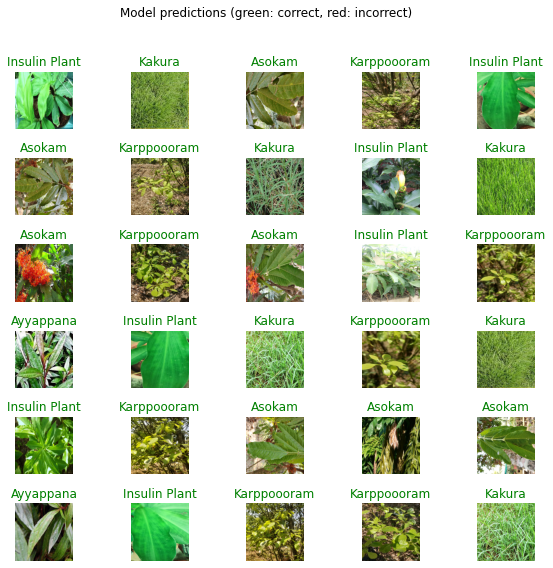

In [ ]:

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")